#      Main Code for extracting data from the ECI website

In [9]:
import requests as req
from bs4 import BeautifulSoup
import pandas as pd
import json
import os

def get_election_summary_results():
    summary_url = 'https://results.eci.gov.in/PcResultGenJune2024/index.htm'
    res = req.get(summary_url)
    res.raise_for_status()
    
    soup = BeautifulSoup(res.text, 'html.parser')
    table = soup.find('table', {'class': 'table'})
    
    if table:
        headers = [th.text.strip() for th in table.find_all('th')]
        rows = table.find_all('tr')
        summary_results = []

        for row in rows:
            cells = row.find_all('td')
            if cells:
                result_data = [cell.text.strip() for cell in cells]
                summary_results.append(result_data)
        
        return headers[0:4], summary_results
    else:
        print("Unable to retrieve election summary !!")
        return None, None

def get_statewise_results(state_code):
    state_result_url = f'https://results.eci.gov.in/PcResultGenJune2024/partywiseresult-{state_code}.htm'
    res = req.get(state_result_url)
    if res.status_code != 200:
        print(f'Failed to retrieve data for state code {state_code}. Status code: {res.status_code}')
        return None, None, None
    
    soup = BeautifulSoup(res.text, 'html.parser')
    table = soup.find('table', {'class': 'table'})
    
    if table:
        state_name = soup.find('div', {'class': 'page-title'}).text.strip().split("2024")[1].split("(")[0]
        headers = [th.text.strip() for th in table.find_all('th')]
        rows = table.find_all('tr')
        state_results = []

        for row in rows:
            cells = row.find_all('td')
            if cells:
                result_data = [cell.text.strip() for cell in cells]
                state_results.append(result_data)
        
        return state_name, headers[0:4], state_results
    else:
        print(f'Data not found for state code: {state_code}')
        return None, None, None

def save_to_json(data, summary_data, file):
    result_data = {'states': {}}
    if summary_data:
        summary_headers, summary_results = summary_data
        result_data['summary'] = {'headers': summary_headers, 'results': summary_results}
    
    for state_code, (state_name, headers, results) in data.items():
        result_data['states'][state_code] = {
            'state_name': state_name,
            'headers': headers,
            'results': results
        }
    
    with open(file, 'w') as f:
        json.dump(result_data, f, indent=4)

def main():
    states_codes = ["S0" + str(state) if state < 10 else "S" + str(state) for state in range(1, 29)]
    ut_codes = ["U0" + str(ut) for ut in range(1, 9)]
    state_codes = states_codes + ut_codes
    all_results = {}

    summary_headers, summary_results = get_election_summary_results()

    for state_code in state_codes:
        state_name, headers, results = get_statewise_results(state_code)
        if headers and results:
            all_results[state_code] = (state_name, headers, results)
    
    save_to_json(all_results, (summary_headers, summary_results), 'general_election_results.json')

if __name__ == '__main__':
    main()


Failed to retrieve data for state code S09. Status code: 404
Failed to retrieve data for state code U04. Status code: 404


##  

## Visualisation of the data

In [5]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [19]:
# Load JSON data into a DataFrame
election_data = pd.read_json('general_election_results.json')

In [21]:
election_data_df = pd.DataFrame(election_data.summary.results[0:], columns=election_data.summary.headers)

In [23]:
election_data_df1 = election_data_df.copy()

In [25]:
election_data_df1.dtypes

Party      object
Won        object
Leading    object
Total      object
dtype: object

In [27]:
election_data_df1.shape

(42, 4)

In [29]:
election_data_df1.head()

,Party,Won,Leading,Total
0,Bharatiya Janata Party - BJP,240,0,240
1,Indian National Congress - INC,99,0,99
2,Samajwadi Party - SP,37,0,37
3,All India Trinamool Congress - AITC,29,0,29
4,Dravida Munnetra Kazhagam - DMK,22,0,22


In [31]:
election_data_df1.tail()

,Party,Won,Leading,Total
37,Aazad Samaj Party (Kanshi Ram) - ASPKR,1,0,1
38,Apna Dal (Soneylal) - ADAL,1,0,1
39,AJSU Party - AJSUP,1,0,1
40,All India Majlis-E-Ittehadul Muslimeen - AIMIM,1,0,1
41,Independent - IND,7,0,7


In [33]:
edc_won = election_data_df1["Won"].astype('int32')

In [35]:
edc_won.head()

0    240
1     99
2     37
3     29
4     22
Name: Won, dtype: int32

In [37]:
edc_parties = election_data_df1["Party"].convert_dtypes()

In [39]:
edc_parties.head()

0           Bharatiya Janata Party - BJP
1         Indian National Congress - INC
2                   Samajwadi Party - SP
3    All India Trinamool Congress - AITC
4        Dravida Munnetra Kazhagam - DMK
Name: Party, dtype: string

#

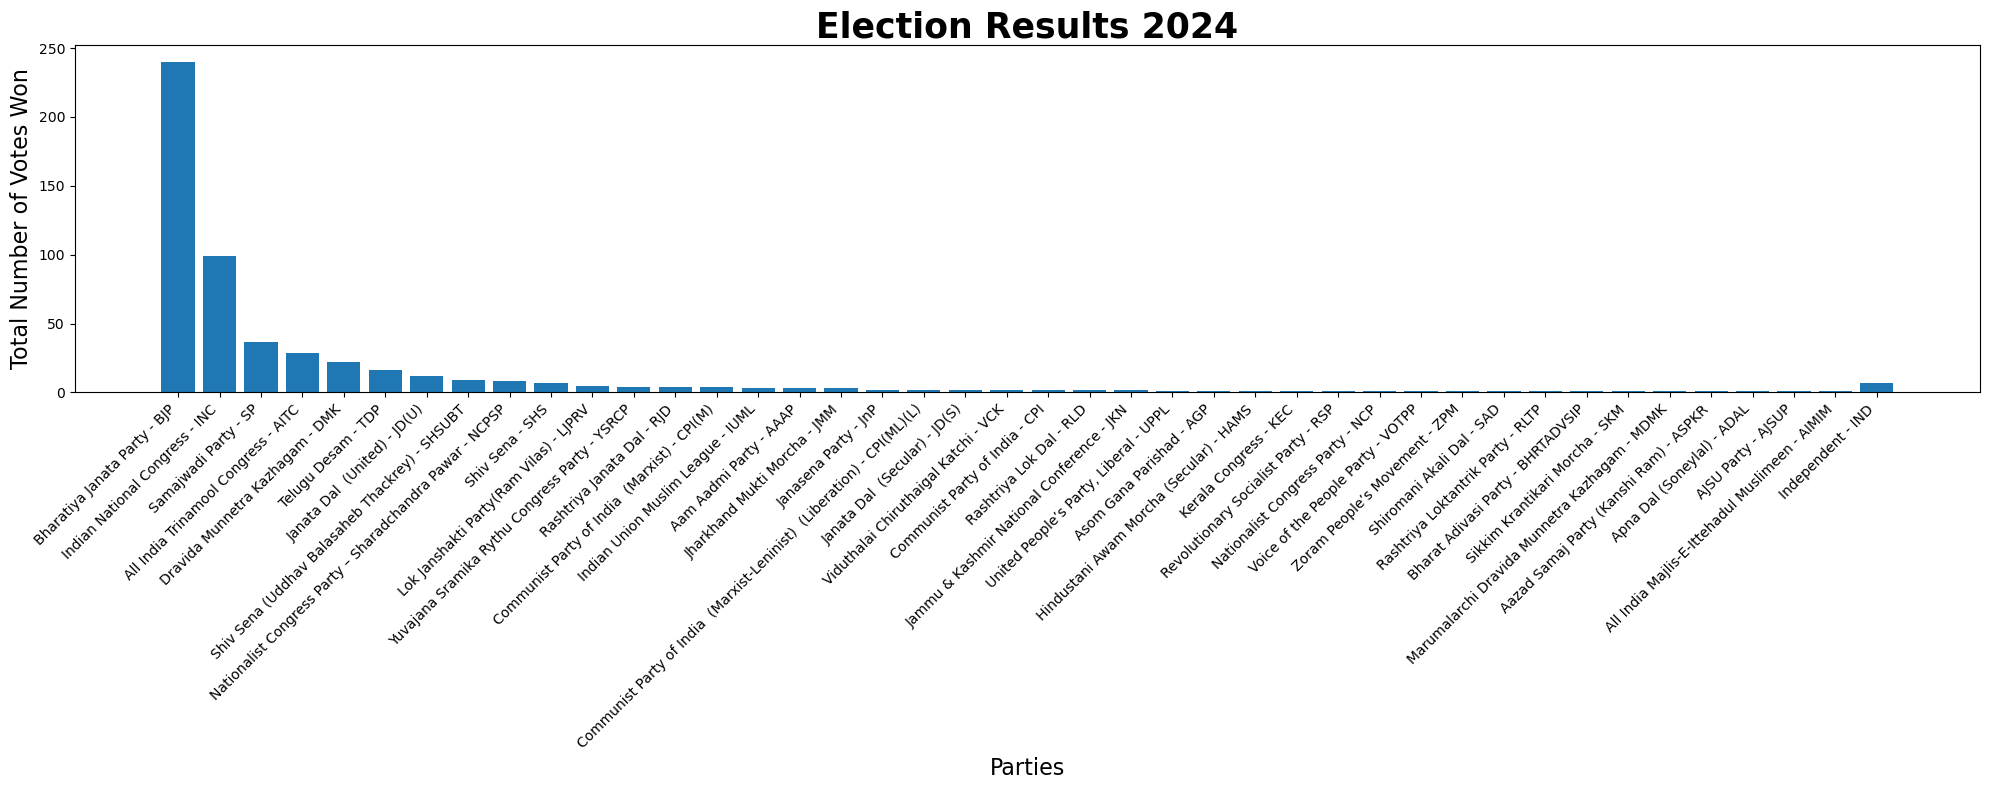

In [42]:
plt.figure(figsize=(20, 8))
plt.bar(edc_parties, edc_won)
plt.xlabel('Parties', fontsize=16)
plt.ylabel('Total Number of Votes Won', fontsize=16)
plt.title('Election Results 2024', fontsize=25, fontweight = 'bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

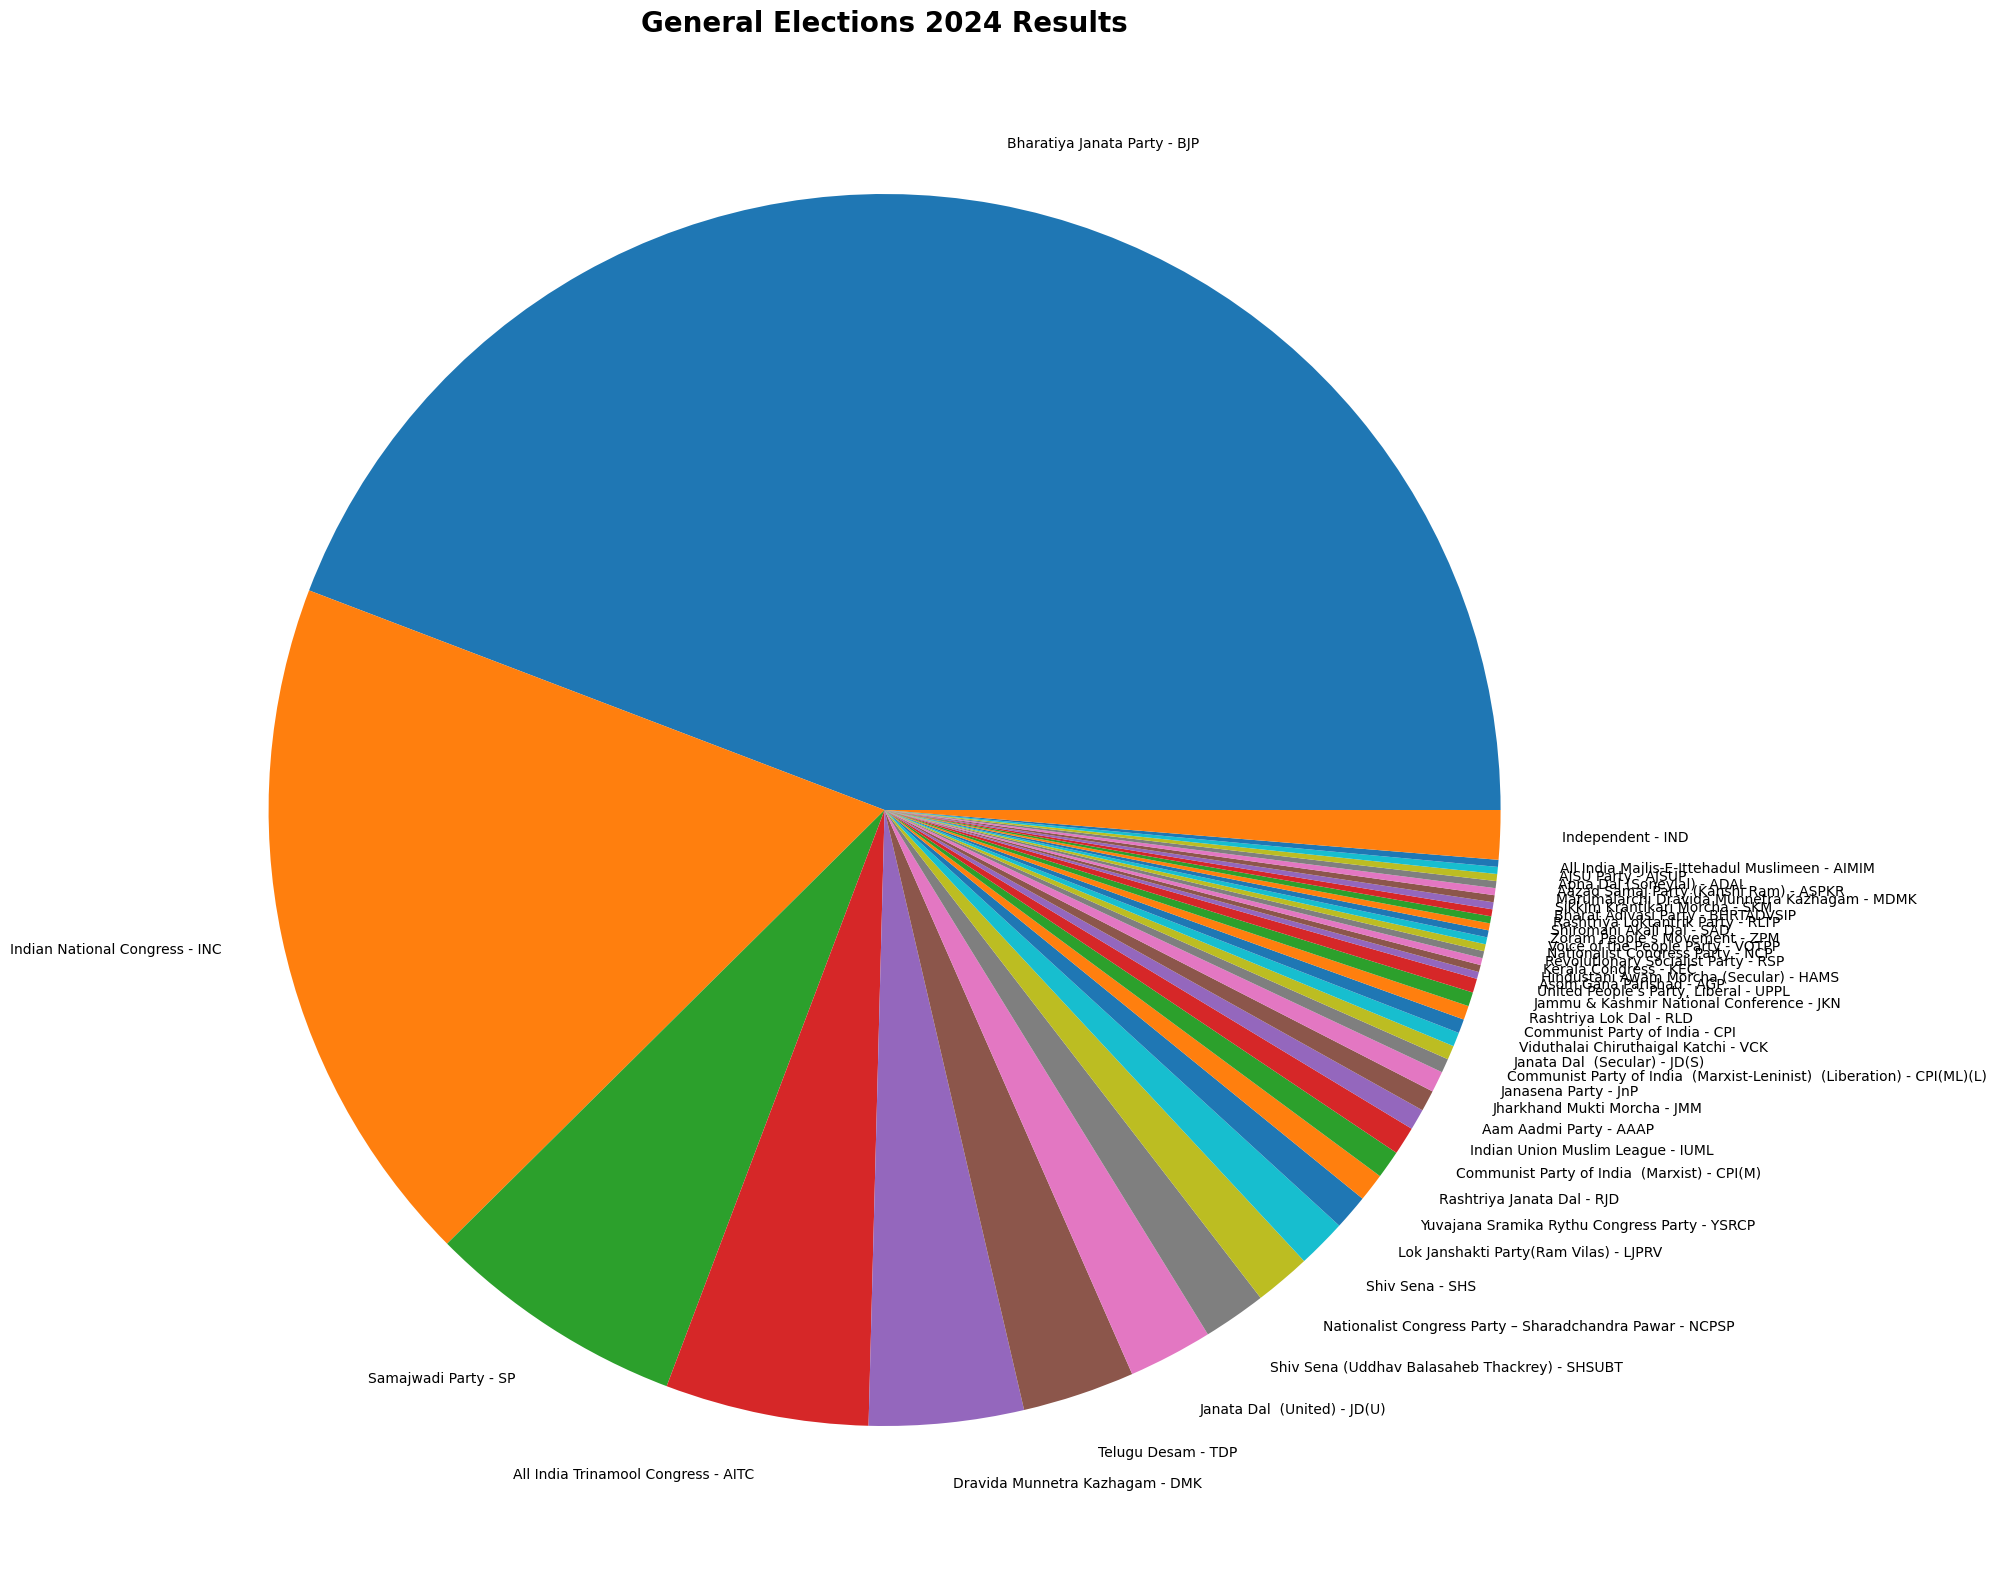

In [44]:
fig = plt.figure(figsize=(25, 20))
plt.pie(edc_won, labels = edc_parties)
plt.title("General Elections 2024 Results", fontsize = 20, fontweight = 'bold')
plt.show()

# Inferences

* No party gained majority of 272 seats, which means that there are chances that government will form along with allies
* BJP gained the highest number of seats (240), congress gained second highest (99)
* There are more chances that BJP will form the government as it only needs 32 seats
* Overall voting results indicates that Indians still have confidence in the current government. 

#

# State Wise Result Analysis 

In [137]:
election_data1 = pd.read_json('general_election_results.json')

In [143]:
election_data1[:-2].columns

Index(['states', 'summary'], dtype='object')

In [147]:
dfs = []

for state_key, state_data in election_data1[:-2]['states'].items():
    state_name = state_data['state_name'].strip()  # Remove leading and trailing whitespace
    
    df = pd.DataFrame(state_data['results'], columns=state_data['headers'])
    df['state_name'] = state_name
    dfs.append(df)
    
final_df = pd.concat(dfs, ignore_index=True)

In [151]:
print(final_df.columns)

Index(['Party', 'Won', 'Leading', 'Total', 'state_name'], dtype='object')
